In [2]:
#Instalar pyarrow
!pip install pyarrow

In [26]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 602.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Leer el archivo Parquet
df = pd.read_parquet("data202414.parquet")

# Visualizar las primeras filas
df.head()

,ANIOCAMPANAPROCESO,ANIOCAMPANA,CODEBELISTA,CODTERRITORIO,CODCOMPORTAMIENTOROLLING,EDAD,FLAGCORREOVALIDADO,FLAGCELULAR,FLAGDIGITAL,DESESTADOCIVIL_CAT,...,DESVIACION_REMESA,FLAGNUEVA,FLAG18,FLAG19,FLAG20,DESV_PEDMIN,DESV_PEDMIN_ADJ,CLASE,TARGET_COBRANZA31_CA,PROM_DIAS_PAGO
0,202414,202410,052370302,57947,1,43,0,1,0,5,...,0.00000,1,0,0,0,224.06000,224.06000,1,1,189.00000
1,202414,202410,049033176,7361,1,31,0,1,0,5,...,0.00000,1,0,0,0,15.86000,15.86000,0,1,189.00000
2,202414,202410,052453461,5033,1,27,0,1,0,5,...,0.00000,1,0,0,0,374.16000,374.16000,1,1,189.00000
3,202414,202410,052363101,32437,1,71,0,1,0,5,...,0.00000,1,0,0,0,51.76000,51.76000,1,1,189.00000
4,202414,202410,052416760,27765,1,29,0,1,0,5,...,0.00000,1,0,0,0,67.67000,67.67000,1,1,189.00000


In [5]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 427.3 kB/s eta 0:00:00a 0:00:01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample

import lightgbm as lgbm
import warnings
warnings.filterwarnings('ignore')


In [7]:
# EDA 

In [8]:
print("Dimensiones:", df.shape)
print("\n Columnas:\n", df.columns)
print("\n Tipos de datos:\n", df.dtypes)
print("\n Valores nulos:\n", df.isnull().sum())
print("\n Primeras filas:\n", df.head())

Dimensiones: (99172, 87)

 Columnas:
 Index(['ANIOCAMPANAPROCESO', 'ANIOCAMPANA', 'CODEBELISTA', 'CODTERRITORIO',
       'CODCOMPORTAMIENTOROLLING', 'EDAD', 'FLAGCORREOVALIDADO', 'FLAGCELULAR',
       'FLAGDIGITAL', 'DESESTADOCIVIL_CAT', 'NRO_PEDIDOS', 'NRO_PEDIDOS_U6C',
       'NRO_PEDIDOS_U18C', 'CANALINGRESO_CAT', 'REALVTAMNFACTURA', 'CODZONA_X',
       'CODREGION', 'EDADBINS', 'PROMEDIOFACTURAS', 'MAXFACTURA', 'MINFACTURA',
       'RATIOFACTURAS', 'REGLA_REVISTA', 'REGLA_CATALOGO', 'REGLA_WEB',
       'REGLA_OTROS', 'LBEL', 'ESIKA', 'CYZONE', 'ANIOCAMPANAINGRESO',
       'GANANCIA_TOTAL', 'DIA_VENC', 'FLAGQUINCENA', 'FLAGINIFIN',
       'ANTIGUEDAD', 'FRAGANCIAS', 'CORPORAL', 'FACIAL', 'PERSONAL',
       'CAMPANAINGRESO', 'DESNIVELSOCIA', 'DESRENDIMIENTOSOCIA',
       'TOTAL_FACTURAS', 'FACTURAS_DEUDA_21_CA', 'FACTURAS_DEUDA_22_CA',
       'FACTURAS_DEUDA_23_CA', 'FACTURAS_DEUDA_24_CA', 'FACTURAS_DEUDA_25_CA',
       'FACTURAS_DEUDA_26_CA', 'FACTURAS_DEUDA_31_CA', 'FACTURAS_DEUDA_4

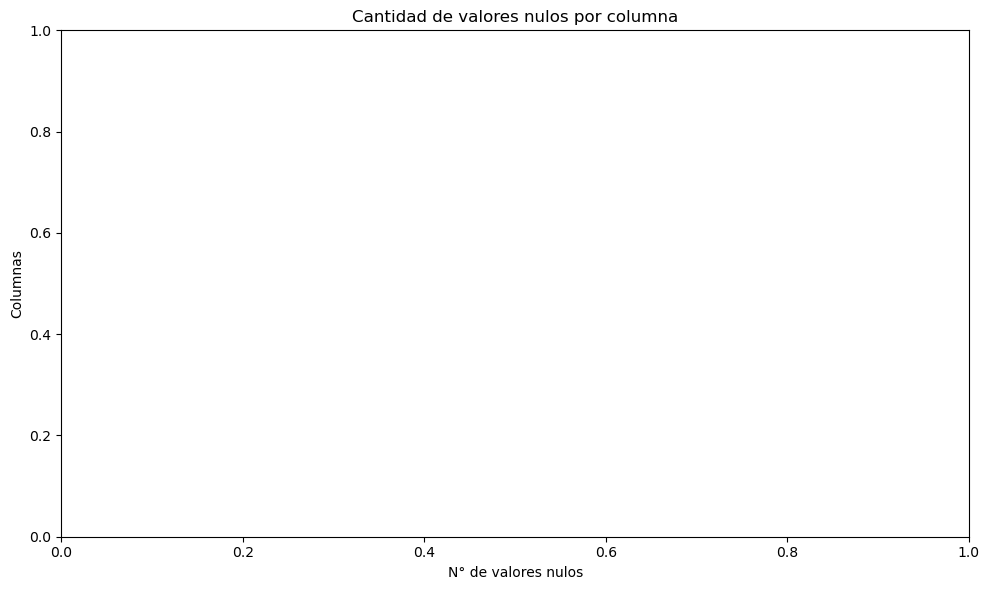

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular nulos
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.values, y=null_counts.index, palette="viridis")
plt.title("Cantidad de valores nulos por columna")
plt.xlabel("N° de valores nulos")
plt.ylabel("Columnas")
plt.tight_layout()
plt.show()


In [15]:
# Convertir nombres de columnas a minúsculas
df.columns = df.columns.str.lower()

In [16]:
# Balance de la categoría Y
df['clase'].value_counts(normalize=True)

clase
0    0.761778
1    0.238222
Name: proportion, dtype: float64

In [17]:
# ========================
# Preprocesamiento
# ========================

# Filtro específico
dataset = df[df.target_cobranza31_ca == 1]

# Reemplazo y conversión de tipos
dataset = dataset.fillna(0)
dataset.codzona_x = dataset.codzona_x.replace("", -1)
dataset.codregion = dataset.codregion.replace("", -1)
dataset.codterritorio = dataset.codterritorio.astype(int)
dataset.codzona_x = dataset.codzona_x.astype(int)
dataset.codregion = dataset.codregion.astype(int)
dataset.aniocampanaingreso = dataset.aniocampanaingreso.astype(int)
dataset.campanaingreso = dataset.campanaingreso.astype(int)

In [18]:
# ========================
# Balanceo
# ========================
def target_upsampler(dataset):
    zero_size = dataset.clase.value_counts()[0]
    df_majority = dataset[dataset.clase == 0]
    df_minority = dataset[dataset.clase == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=(zero_size // 4),
        random_state=123,
    )
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

df_upsampled = target_upsampler(dataset)

In [19]:
# ========================
# Split Data
# ========================
X = df_upsampled.drop(["codebelista", "clase", "aniocampana"], axis=1)
y = df_upsampled["clase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [28]:
print("Valores únicos en y_train:", y_train.unique())
print("Tipo de datos en y_train:", y_train.dtype)

Valores únicos en y_train: [Decimal('0') Decimal('1')]
Tipo de datos en y_train: object


In [29]:
# Asegurar que y_train e y_test sean enteros
y_train = y_train.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

In [31]:
# Convierte todas las columnas posibles a numéricas 
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Rellena valores faltantes que hayan aparecido
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [33]:
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# ========================
# 1. LightGBM
# ========================
model_lgbm = LGBMClassifier(
    objective="binary",
    max_depth=30,
    learning_rate=0.01,
    min_child_samples=20,
    num_leaves=25,
    feature_fraction=0.7,
    bagging_fraction=0.7,
    bagging_freq=3,
    boosting_type="gbdt",
    reg_alpha=0,
    reg_lambda=0.1,
    n_estimators=5000,
    random_state=42
)

model_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(stopping_rounds=200)]
)

pred_lgbm = model_lgbm.predict(X_test)
report_lgbm = classification_report(y_test, pred_lgbm, output_dict=True)

# ========================
# 2. Random Forest
# ========================
model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
report_rf = classification_report(y_test, pred_rf, output_dict=True)

# ========================
# 3. Logistic Regression
# ========================
model_lr = LogisticRegression(max_iter=500, random_state=42)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
report_lr = classification_report(y_test, pred_lr, output_dict=True)

# ========================
# 4. XGBoost
# ========================
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
report_xgb = classification_report(y_test, pred_xgb, output_dict=True)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 13292, number of negative: 52811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

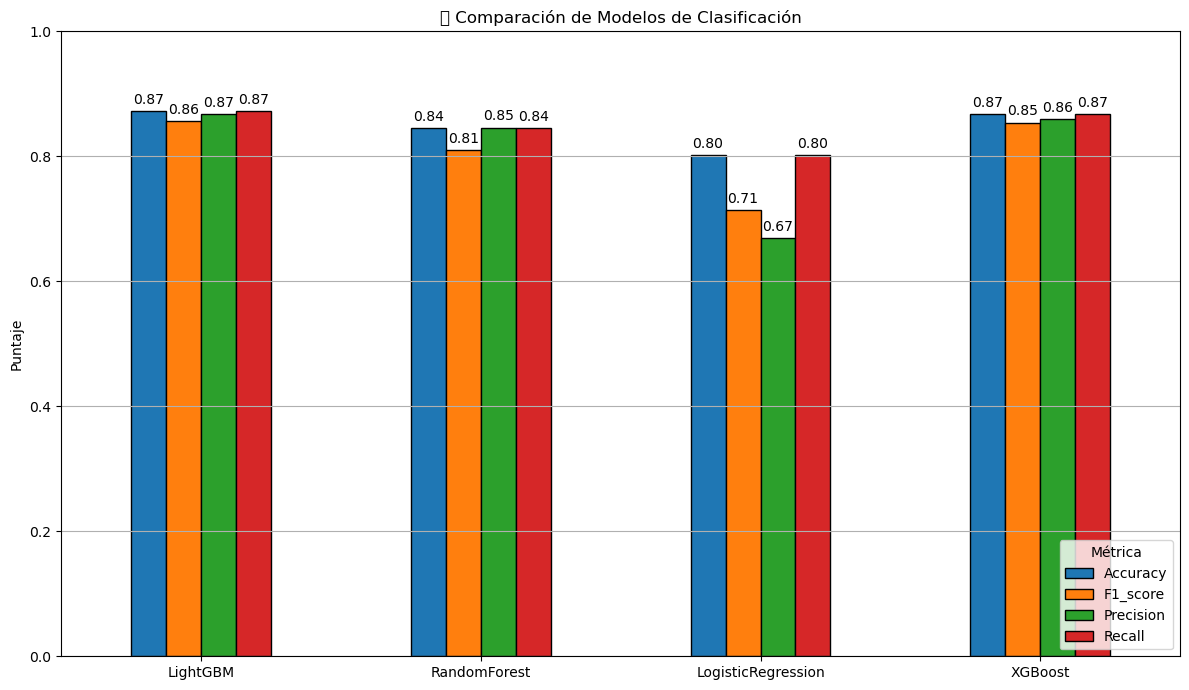

In [35]:
# Diccionario con métricas reales (asegúrate de que estén definidas)
metrics_summary = {
    "LightGBM": {
        "Accuracy": report_lgbm["accuracy"],
        "F1_score": report_lgbm["weighted avg"]["f1-score"],
        "Precision": report_lgbm["weighted avg"]["precision"],
        "Recall": report_lgbm["weighted avg"]["recall"]
    },
    "RandomForest": {
        "Accuracy": report_rf["accuracy"],
        "F1_score": report_rf["weighted avg"]["f1-score"],
        "Precision": report_rf["weighted avg"]["precision"],
        "Recall": report_rf["weighted avg"]["recall"]
    },
    "LogisticRegression": {
        "Accuracy": report_lr["accuracy"],
        "F1_score": report_lr["weighted avg"]["f1-score"],
        "Precision": report_lr["weighted avg"]["precision"],
        "Recall": report_lr["weighted avg"]["recall"]
    },
    "XGBoost": {
        "Accuracy": report_xgb["accuracy"],
        "F1_score": report_xgb["weighted avg"]["f1-score"],
        "Precision": report_xgb["weighted avg"]["precision"],
        "Recall": report_xgb["weighted avg"]["recall"]
    }
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics_summary).T

# Gráfico
ax = metrics_df.plot(kind="bar", figsize=(12, 7), edgecolor='black')
plt.title("📊 Comparación de Modelos de Clasificación")
plt.ylabel("Puntaje")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.legend(loc="lower right", title="Métrica")

# Añadir etiquetas a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()



In [36]:
import pickle

# Define el nombre del archivo
filename = "modelo_lightgbm_final.pkl"

# Guarda el modelo entrenado
with open(filename, "wb") as f:
    pickle.dump(model_lgbm, f)

print(f"✅ Modelo guardado como '{filename}'")

✅ Modelo guardado como 'modelo_lightgbm_final.pkl'
